In [24]:
import os
import re
import glob
import pandas as pd
from utils import set_font

from PIL import Image

In [3]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
set_font()

In [4]:
df_meta = pd.read_csv('data/meta.csv')
df_meta.head()

,filetype,class1,class2,class3,filepath
0,properties,구이,구이,갈비구이,E:/Data/kfood\구이\구이\갈비구이\crop_area.properties
1,jpg,구이,구이,갈비구이,E:/Data/kfood\구이\구이\갈비구이\Img_000_0000.jpg
2,jpg,구이,구이,갈비구이,E:/Data/kfood\구이\구이\갈비구이\Img_000_0001.jpg
3,jpg,구이,구이,갈비구이,E:/Data/kfood\구이\구이\갈비구이\Img_000_0002.jpg
4,jpg,구이,구이,갈비구이,E:/Data/kfood\구이\구이\갈비구이\Img_000_0003.jpg


In [5]:
df = pd.DataFrame({'id':df_meta[df_meta.filetype=='jpg'].filepath.str.extract(r'\\([^\\]+$)')[0], 'label':df_meta[df_meta.filetype=='jpg'].class1})
np.random.seed(0)
# df['subset'] = np.where(df.index.isin(np.random.choice(df.index, int(df.shape[0]*0.7))), 'train', 'validation')

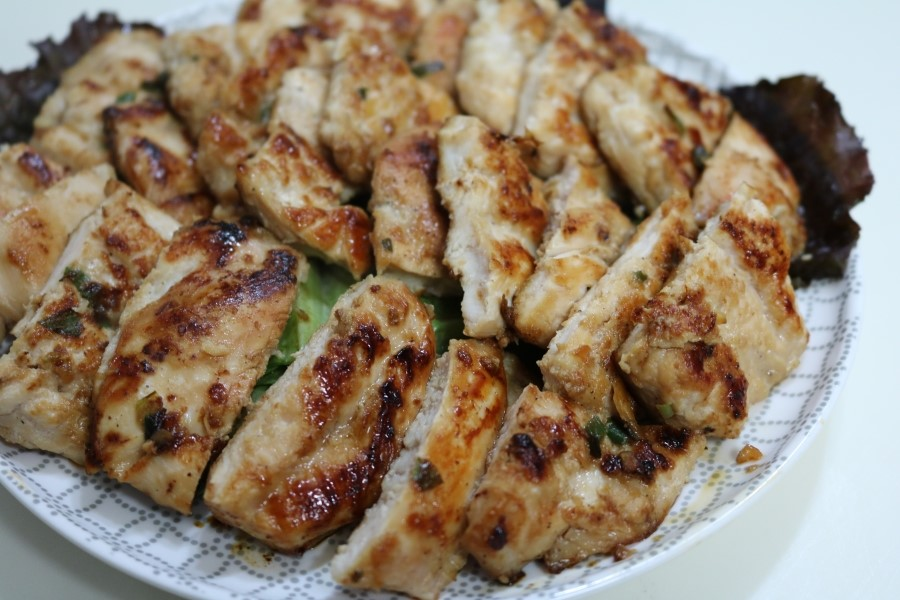

In [6]:
for image_path in df_meta.filepath[1:2]:
    display(Image.open(str(image_path)))

In [7]:
df.head()

,id,label
1,Img_000_0000.jpg,구이
2,Img_000_0001.jpg,구이
3,Img_000_0002.jpg,구이
4,Img_000_0003.jpg,구이
5,Img_000_0004.jpg,구이


In [8]:
df = pd.DataFrame({'id':df_meta[df_meta.filetype=='jpg'].filepath, 'label':df_meta[df_meta.filetype=='jpg'].class1})
np.random.seed(0)
df['subset'] = np.where(df.index.isin(np.random.choice(df.index, int(df.shape[0]*0.7))), 'train', 'validation')

In [9]:
image_count = df[df.subset=='train'].shape[0]
CLASS_NAMES = np.unique(df.label.values)
CLASS_NAMES

array(['구이', '국', '기타', '김치', '나물', '떡', '만두', '면', '무침', '밥', '볶음', '쌈',
       '음청류', '장', '장아찌', '적', '전', '전골', '조림', '죽', '찌개', '찜', '탕', '튀김',
       '한과', '해물', '회'], dtype=object)

## Slow

In [10]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [22]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
train_data_gen = image_generator.flow_from_dataframe(dataframe=df,
                                                     directory='/',
                                                     x_col='id',
                                                     y_col='label',
                                                     subset='training',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical",
                                                     classes = list(CLASS_NAMES))

Found 147834 validated image filenames belonging to 27 classes.


In [13]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

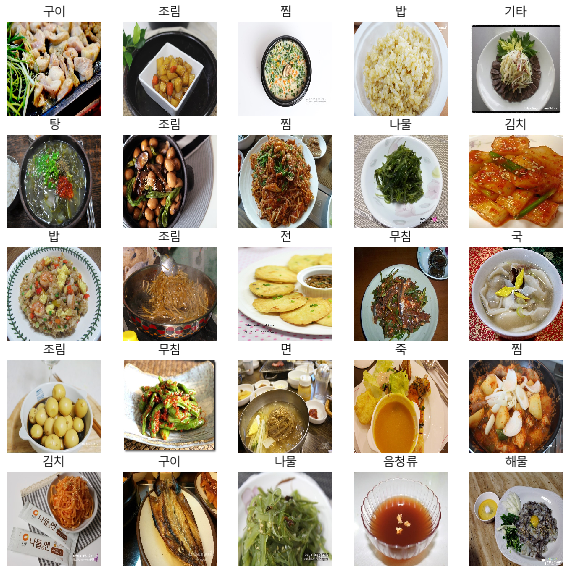

In [14]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## Fast Laod

In [15]:
list_ds = tf.data.Dataset.list_files(df.id.values)

In [34]:

list_ds

<DatasetV1Adapter shapes: (), types: tf.string>

In [85]:
for f in list_ds.take(5):
    parts = tf.strings.split(f, os.path.sep)
    print(parts[3].numpy())
    print(parts[3].numpy() == CLASS_NAMES)
#   print(f.numpy())

b'\xeb\xb3\xb6\xec\x9d\x8c'
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
b'\xeb\xb0\xa5'
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
b'\xeb\xa9\xb4'
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
b'\xed\x83\x95'
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
b'\xea\xb5\xad'
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]


In [51]:
'd'==np.array(['a','b','c','d'])

array([False, False, False,  True])

In [86]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second is the class-directory
  return parts[3].numpy() == CLASS_NAMES

In [87]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [88]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [89]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

AttributeError: 'Tensor' object has no attribute 'numpy'

In [75]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  False


In [27]:
## 학습을 위한 기본 메소드

In [70]:
CLASS_NAMES==np.array(['a'])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])